# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* Gustavo Heisser
* Agustin Rojas

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) completado y con las celdas ejecutas a myommi@untref.edu.ar.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from scipy.io.wavfile import write
import simpleaudio as sa
import sounddevice as sd
import time

## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [4]:
def ruidoRosa_voss(t, fs=44100, ncols=16):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    rcols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import scipy as sp
        from scipy.io.wavfile import write
        
        ruidoRosa_voss(10)
    """
    nrows = t*fs

    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    # Generación de archivo de audio .wav
    filename = '../audio/ruidoRosa.wav'
    write(filename, fs, total)
    
    return total

Llamar la función.

In [5]:
ruidoRosa = ruidoRosa_voss(10)

Realizar una función para visualizar el dominio temporal de la señal.

In [1]:
def visualizar (audioData, fs=44100):
    '''
        Funcion para visualizar audio
    '''

    length = audioData.shape[0] / fs
    t = np.linspace(0., length, audioData.shape[0])
    #t = np.arange(0, len(audioData), 1)/ fs
    
    plt.rcParams['figure.figsize'] = (15, 5) # set plot size
    #plt.plot(t, audioData)
    plt.plot(t, audioData / (2.**15))
    plt.title('Audio Waveform',size=16);
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud [int16]")

Llamar a la función.

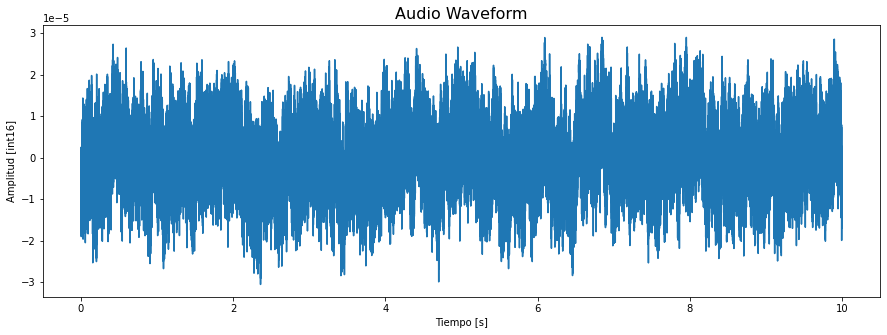

In [38]:
visualizar(ruidoRosa)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

Text(0, 0.5, 'Nivel [dB]')

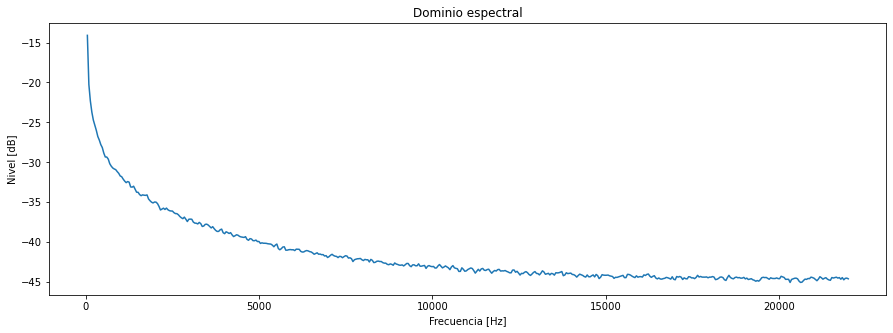

In [39]:
# Cambio de coma por punto
with open("../audio/espectro.txt") as f_input:

    text = [l.replace(",", ".") for l in f_input]

# Creo un array con los pares ordenados 
data = np.loadtxt(text, skiprows=1)

frecuencia, nivel = data.T
plt.plot(frecuencia,nivel)
plt.title('Dominio espectral')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Nivel [dB]")

Reproducir resultado.

In [22]:
fs = 44100
sd.play(ruidoRosa, fs)
sd.wait()

> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [21]:
def sine_sweep(T, f_inicial, f_final, fs=44100):
    """
    Generacion de un sine sweep y su filtro inverso
    
    Parametros
    ----------
    T : float
        Valor temporal en segundos, este determina la duración del sine sweep generado.
    f_inicial: int
        Frecuencia inicial del sine sweep en Hz.
    f_final: int
        Frecuencia final del sine sweep en Hz.
    fs: int   
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: Dos NumPy arrays
        Datos de las señales generadas.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 10 segundos con sine sweep de 20 a 20000 Hz 
    a una frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import scipy as sp
        from scipy.io.wavfile import write
        
        sine_sweep(10,20,20000)
    """
    # Calculo de parametros
    omega_inicial = 2*np.pi*f_inicial
    omega_final = 2*np.pi*f_final
    n = T*fs
    K = np.float16((T * omega_inicial) / np.log(omega_final/omega_inicial))
    L = np.float16(T / np.log(omega_final/omega_inicial))
    t = np.linspace(0,T,n)

    # Funcion sine sweep
    f = np.sin(K*(np.exp(t/L)-1))
    
    ## Normalizado
    valor_max = max(abs(max(f)),abs(min(f)))
    sine_sweep = f / valor_max
    
    # Generación de archivo de audio .wav
    filename = '../audio/sinesweep.wav'
    write(filename, fs, sine_sweep)
    
    # Funcion filtro inverso
    w = ((K/L)*np.exp(t/L))
    m = (omega_inicial/(2*np.pi*w))
    k = m*f[::-1]
    
    ## Normalizado
    valor_max = max(abs(max(k)),abs(min(k)))
    filtro_inverso = k / valor_max
    
    # Generación de archivo de audio .wav
    filename = '../audio/filtroinverso.wav'
    write(filename, fs, filtro_inverso)
    
    return sine_sweep, filtro_inverso

Llamar la función.

In [22]:
sine_sweep, filtro_inverso = sine_sweep(10,20,20000)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

Text(0, 0.5, 'Nivel [dB]')

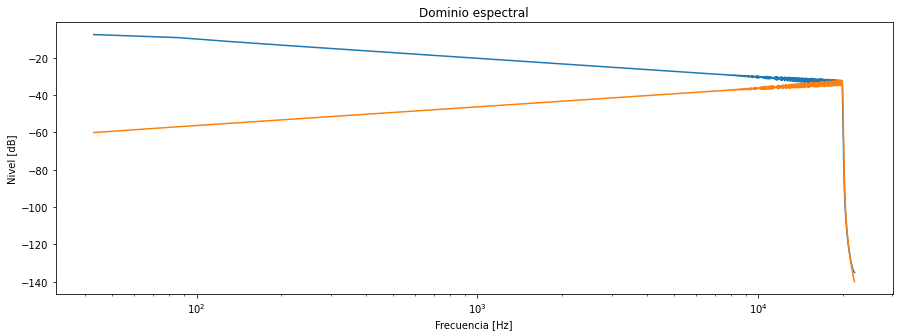

In [88]:
# Cambio de coma por punto
with open("../audio/espectro sinesweep.txt") as f_input:

    text = [l.replace(",", ".") for l in f_input]

# Creo un array con los pares ordenados 
data = np.loadtxt(text, skiprows=1)

frecuencia, nivel = data.T
plt.plot(frecuencia,nivel)

# Cambio de coma por punto
with open("../audio/espectro filtroinverso.txt") as f_input:

    text = [l.replace(",", ".") for l in f_input]

# Creo un array con los pares ordenados 
data = np.loadtxt(text, skiprows=1)

frecuencia, nivel = data.T
plt.semilogx(frecuencia,nivel)
plt.title('Dominio espectral')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Nivel [dB]")

Reproducir resultados.

In [23]:
fs = 44100
sd.play(sine_sweep, fs)
sd.wait()

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [102]:
def reproduccion_adquisicion(t, audio, device_in=sd.default.device[0], device_out=sd.default.device[1], fs=44100):
    """
    Reproduccion de un NumPy array y grabacion en simultaneo.
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración de la grabacion.
    audio: NumPy array
        Array que se desea reproducir.
    device_in: int
        Numero de dispositivo de entrada. En caso de no conocer el numero de dispositivo, consultar usando sd.query_devices(). 
    device_out: int
        Numero de dispositivo de salida. En caso de no conocer el numero de dispositivo, consultar usando sd.query_devices(). 
    fs: int   
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un `.wav` desde un numpy array de 5 segundos a partir de la grabacion en simultaneo a la reproduccion de otro array
    ingresado como segundo argumento, a una frecuencia de muestreo de 44100 Hz. Se utilizan los dispositivos de entrada y salida por default.
    
        import numpy as np
        import scipy as sp
        from scipy.io.wavfile import write
        import sounddevice as sd
        
        reproduccion_adquisicion(5, audio)
    """
    
    # Calculo de muestras totales
    n = t*fs 
    
    # Creacion del array a reescribir, si t es menor a la duracion del audio, se recorta. De lo contrario, se rellena con ceros (silencio).
    if n <= len(audio):
        data = audio[:n]
    else :
        data = np.concatenate((audio, np.zeros(n-len(audio))))
    
    # Para la reproduccion y escritura simultanea se utiliza playrec de sounddevice
    recording = sd.playrec(data, samplerate=44100, channels=2, blocking=True, device=[device_in,device_out])

    # Creacion del archivo .wav
    filename = '../audio/output.wav'
    write(filename, fs, prueba)
    
    return recording

Llamar la función.

In [100]:
# Se consultan los dispositivos de entrada y salida
sd.query_devices()

   0 Asignador de sonido Microsoft - Input, MME (2 in, 0 out)
>  1 Línea (2- ConnectAUDIO2/4), MME (2 in, 0 out)
   2 Micrófono (Realtek High Definit, MME (2 in, 0 out)
   3 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
<  4 Altavoces (2- ConnectAUDIO2/4), MME (0 in, 2 out)
   5 Altavoces (Realtek High Definit, MME (0 in, 2 out)
   6 Controlador primario de captura de sonido, Windows DirectSound (2 in, 0 out)
   7 Línea (2- ConnectAUDIO2/4), Windows DirectSound (2 in, 0 out)
   8 Micrófono (Realtek High Definition Audio), Windows DirectSound (2 in, 0 out)
   9 Controlador primario de sonido, Windows DirectSound (0 in, 2 out)
  10 Altavoces (2- ConnectAUDIO2/4), Windows DirectSound (0 in, 2 out)
  11 Altavoces (Realtek High Definition Audio), Windows DirectSound (0 in, 2 out)
  12 iConnectivity ASIO Driver, ASIO (2 in, 4 out)
  13 Altavoces (Realtek High Definition Audio), Windows WASAPI (0 in, 2 out)
  14 Altavoces (2- ConnectAUDIO2/4), Windows WASAPI (0 in, 2 out)
  15 Lín

In [98]:
# Se llama a la funcion
recording = reproduccion_adquisicion(5, sine_sweep, 2, 4)

# Se reproduce el resultado
fs = 44100
sd.play(recording, fs)
sd.wait()

¿Cómo se podría medir la latencia de la función?

In [99]:
# Se puede calcular la latencia a partir de la funcion time que mide la hora, antes y despues de ejecutar la funcion, restando al total el tiempo que dura la grabacion.
t = 15
t1 = time.time()
recording = reproduccion_adquisicion(t, sine_sweep, 2, 4)
dt1 = time.time() - t1 - t

print('Latencia de la funcion:', dt1, 's')

Latencia de la funcion: 0.2745685577392578 s
